In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Loading Data

In [4]:
#Loading Data
# !ls "/content/drive/MyDrive/Colab Notebooks/data/image"

In [5]:
# nzip Dataset
# !ls
# !7za -y e "/content/drive/MyDrive/Colab Notebooks/data/image/origin.7z.*"

#Store Dataset in drive

In [6]:
#Store Dataset in drive
# !mkdir "/content/drive/MyDrive/Colab Notebooks/processed_data"
# !cp -r ./origin "/content/drive/MyDrive/Colab Notebooks/processed_data/"

#import Useful Libraries

In [7]:
#import Useful Libraries
import numpy as np
import os
import glob
import pandas as pd
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

#Preprocessing

In [8]:
##images_dir ="/content/drive/MyDrive/Colab Notebooks/new_data"
#images_dir ="/content/drive/MyDrive/Colab Notebooks/sample_data"
images_folder_path="/content/drive/MyDrive/Colab Notebooks/processed_data/origin"
label_file_path="/content/drive/MyDrive/Colab Notebooks/data/label/label.lst"

In [9]:
images =list(glob.glob(os.path.join(images_folder_path, '*.jpg')))
# PIL.Image.open(str(images[1]))

In [10]:
df_info=pd.read_csv(label_file_path, sep=" ",header=None)
df_info.columns=['image_name','face_id_in_image','face_box_top','face_box_left','face_box_right','face_box_bottom','face_box_cofidence','expression_label']
df_info.head()

,image_name,face_id_in_image,face_box_top,face_box_left,face_box_right,face_box_bottom,face_box_cofidence,expression_label
0,angry_actor_104.jpg,0,28,113,226,141,22.9362,0
1,angry_actor_109.jpg,0,31,157,345,219,50.3056,0
2,angry_actor_120.jpg,1,53,53,372,372,13.9434,2
3,angry_actor_13.jpg,0,77,51,362,388,85.8104,3
4,angry_actor_132.jpg,0,95,31,412,476,82.3948,0


#check target labels

In [11]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = df_info['expression_label'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['expression_label', 'number']
emotion_counts['expression_label'] = emotion_counts['expression_label'].map(emotion_map)
emotion_counts

,expression_label,number
0,Angry,3671
1,Fear,1088
2,Happy,30537
3,Neutral,34883
4,Sad,10559
5,Digust,3995
6,Surprise,7060


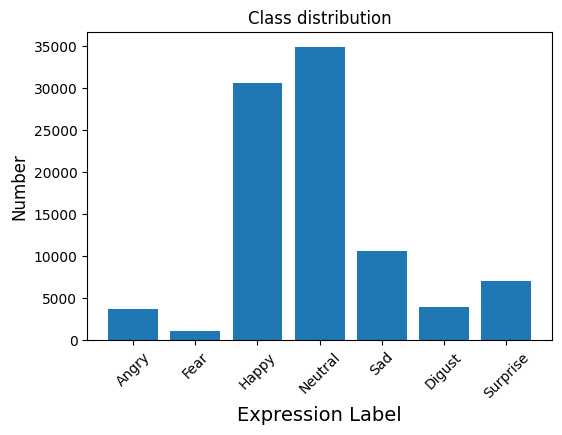

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
emotion_counts = pd.DataFrame(emotion_counts, columns=["expression_label", "number"])
plt.figure(figsize=(6, 4))
plt.bar(emotion_counts.expression_label, emotion_counts.number)
plt.title('Class distribution')
plt.xlabel('Expression Label', fontsize=14)
plt.ylabel('Number', fontsize=12)
plt.xticks(rotation=45) # To rotate the x-axis labels for better visibility
plt.show()


In [13]:
df_info.value_counts()


image_name                  face_id_in_image  face_box_top  face_box_left  face_box_right  face_box_bottom  face_box_cofidence  expression_label
awe_teacher_108.jpg         1                 600           1524           1572            648              72.4882             3                   37
astound_expression_400.jpg  3                 288           308            388             368              72.5160             3                   16
awe_student_400.jpg         2                 664           388            436             712              82.8833             6                   13
amazed_chinese_563.jpg      3                 652           1908           1956            700              56.7663             6                   12
                            1                 176           576            624             224              57.5098             6                   12
                                                                                                    

In [14]:
df_sel=df_info[df_info.face_box_cofidence > 80]
#print(df_sel)
len(df_sel)


12127

In [15]:
df_sel.shape


(12127, 8)

In [16]:
df_sel.columns

Index(['image_name', 'face_id_in_image', 'face_box_top', 'face_box_left',
       'face_box_right', 'face_box_bottom', 'face_box_cofidence',
       'expression_label'],
      dtype='object')

In [17]:
df_sel.image_name

3                    angry_actor_13.jpg
4                   angry_actor_132.jpg
5                   angry_actor_137.jpg
9                   angry_actor_150.jpg
12                  angry_actor_161.jpg
                      ...              
91778       surprised_expression_37.jpg
91780      surprised_expression_289.jpg
91787    expressionless_husband_673.jpg
91789      surprised_expression_381.jpg
91790      surprised_expression_395.jpg
Name: image_name, Length: 12127, dtype: object

#Crop Images

In [18]:
import cv2
import os
import concurrent.futures


In [19]:
x = []
y = []
def process_image(row):
  img_name = row["image_name"]
  x1 = row["face_box_left"]
  y1 = row["face_box_top"]
  x2 = row["face_box_right"]
  y2 = row["face_box_bottom"]
  label = row["expression_label"]
  img_path = os.path.join(images_folder_path, img_name)
  image = cv2.imread(img_path)
  if image is not None:
    cropped = image[y1:y2, x1:x2]
  else:
    return None, None
  if cropped is not None:
    resized_face = cv2.resize(cropped, (64, 64))
  else:
   return None, None
  return resized_face, label

# Function to process images in parallel

In [20]:
# Function to process images in parallel
def process_images_in_parallel(dataframe):
  with concurrent.futures.ThreadPoolExecutor() as executor:

      future_to_row = {executor.submit(process_image, row): row for i, row in dataframe.sample(10000).iterrows()}
      for future in concurrent.futures.as_completed(future_to_row):
         row = future_to_row[future]
         resized_face, label = future.result()
         if resized_face is not None:
             x.append(resized_face)
             y.append(label)


# Call the function to process images in parallel

In [21]:
process_images_in_parallel(df_sel)


#Data preparation

In [23]:
import numpy as np
X= np.array(x)
y= np.array(y)

In [24]:
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical


# Step 1: Normalization

In [25]:
X_normalized = X / 255.0


# Step 2: Sampling (optional)

In [26]:
sample_size = 30000
random_indices = np.random.choice(len(X_normalized), size=sample_size )
X_sampled = X_normalized[random_indices]
Y_sampled = y[random_indices]


# Step 3: Encoding (for classification task)

In [27]:
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y_sampled)


# Step 4: Train-Test Split

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X_sampled, Y_encoded, test_size=0.2, random_state=42)


# Step 5: Load and Fine-tune VGG16 Model

In [29]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))


# Freeze the layers so that they are not updated during training

In [30]:
for layer in vgg16.layers:
    layer.trainable = False

# Add custom layers on top of VGG16 for classification

In [31]:
x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

# Create the model

In [32]:
model = Model(inputs=vgg16.input, outputs=predictions)

# Compile the model

In [33]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model

In [34]:
# Train the model
model.fit(X_train, Y_train, batch_size=32, epochs=3, validation_data=(X_test, Y_test))


Epoch 1/3
750/750 [==============================] - 1662s 2s/step - loss: 0.9656 - accuracy: 0.6650 - val_loss: 0.7433 - val_accuracy: 0.7442
Epoch 2/3
750/750 [==============================] - 1563s 2s/step - loss: 0.5154 - accuracy: 0.8285 - val_loss: 0.3650 - val_accuracy: 0.8778
Epoch 3/3
750/750 [==============================] - 1567s 2s/step - loss: 0.2372 - accuracy: 0.9251 - val_loss: 0.1920 - val_accuracy: 0.9397


# Calculate accuracy on test data

In [35]:
loss, accuracy = model.evaluate(X_test, Y_test, batch_size=32)
print(f"Test accuracy: {accuracy:.2f}")

188/188 [==============================] - 309s 2s/step - loss: 0.1920 - accuracy: 0.9397
Test accuracy: 0.94
